In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from sklearn import datasets
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

def dbscan(X, eps, minPts):
    n = X.shape[0]
    labels = np.full(n, -1, dtype=int)
    cluster_id = 0
    visited = np.zeros(n, dtype=bool)

    # 获取邻域内的点
    def region_query(p):
        distances = euclidean_distances(X[p].reshape(1, -1), X).flatten()
        return np.where(distances <= eps)[0]

    # 扩展聚类
    def expand_cluster(p, neighbors):
        labels[p] = cluster_id
        queue = deque(neighbors)
        while queue:
            point = queue.popleft()
            if not visited[point]:
                visited[point] = True
                point_neighbors = region_query(point)
                if len(point_neighbors) >= minPts:
                    queue.extend(point_neighbors)
                if labels[point] == -1:
                    labels[point] = cluster_id

    for p in range(n):
        if not visited[p]:
            visited[p] = True
            p_neighbors = region_query(p)
            if len(p_neighbors) >= minPts:
                expand_cluster(p, p_neighbors)
                cluster_id += 1

    return labels

In [63]:
# 加载Iris数据集
iris = datasets.load_iris()
X = iris.data
y = iris.target

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 添加噪声点
np.random.seed(42)
noise = np.random.uniform(-3, 3, (20, 4))  # 在四个特征上均匀分布的噪声
X_noisy = np.vstack([X_scaled, noise])

# 测试不同的eps和minPts
eps_values = np.arange(0.1, 2.0, 0.1)
minPts_values = range(2, 6)
best_ari = -1
best_eps = None
best_minPts = None

for eps in eps_values:
    for minPts in minPts_values:
        labels = dbscan(X_scaled, eps, minPts)
        # 只计算有效聚类的ARI（忽略全部为噪声的情况）
        if len(set(labels)) > 1:
            ari = adjusted_rand_score(y, labels)
            print(f'EPS: {round(eps, 2)}, minPts: {minPts}, Adjusted Rand Index: {ari}')
            
            if ari > best_ari:
                best_ari = ari
                best_eps = eps
                best_minPts = minPts

# 打印最佳结果
print(f'Best EPS: {round(best_eps, 2)}, Best minPts: {best_minPts}, Best ARI: {best_ari}')


EPS: 0.1, minPts: 2, Adjusted Rand Index: 0.00036284338590934
EPS: 0.2, minPts: 2, Adjusted Rand Index: 0.046409843511292785
EPS: 0.2, minPts: 3, Adjusted Rand Index: 0.024361549156852725
EPS: 0.2, minPts: 4, Adjusted Rand Index: 0.007556094556967286
EPS: 0.3, minPts: 2, Adjusted Rand Index: 0.14851265243399153
EPS: 0.3, minPts: 3, Adjusted Rand Index: 0.15871578416858287
EPS: 0.3, minPts: 4, Adjusted Rand Index: 0.1519677662246593
EPS: 0.3, minPts: 5, Adjusted Rand Index: 0.08990820404362948
EPS: 0.4, minPts: 2, Adjusted Rand Index: 0.3751575926283546
EPS: 0.4, minPts: 3, Adjusted Rand Index: 0.3597005625904818
EPS: 0.4, minPts: 4, Adjusted Rand Index: 0.4078708710738588
EPS: 0.4, minPts: 5, Adjusted Rand Index: 0.32664704636140496
EPS: 0.5, minPts: 2, Adjusted Rand Index: 0.45449685048131594
EPS: 0.5, minPts: 3, Adjusted Rand Index: 0.4525365298375957
EPS: 0.5, minPts: 4, Adjusted Rand Index: 0.44747527301949164
EPS: 0.5, minPts: 5, Adjusted Rand Index: 0.43268639618265736
EPS: 0.6, 

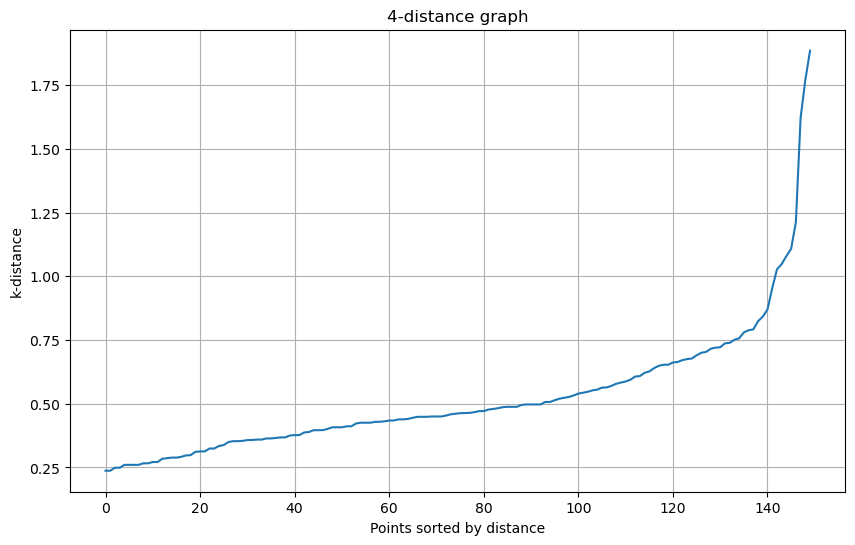

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 计算k-距离
def k_distances(X, k):
    dist_matrix = euclidean_distances(X)
    sorted_dist_matrix = np.sort(dist_matrix, axis=1)
    k_dist = sorted_dist_matrix[:, k]
    return k_dist

# 计算k-距离并绘制k-距离图
k = 4  # 通常选取minPts-1，假设我们正在考虑minPts为5
k_dist = k_distances(X_scaled, k)
k_dist_sorted = np.sort(k_dist)
plt.figure(figsize=(10, 6))
plt.plot(k_dist_sorted)
plt.ylabel('k-distance')
plt.xlabel('Points sorted by distance')
plt.title('4-distance graph')
plt.grid(True)
plt.show()


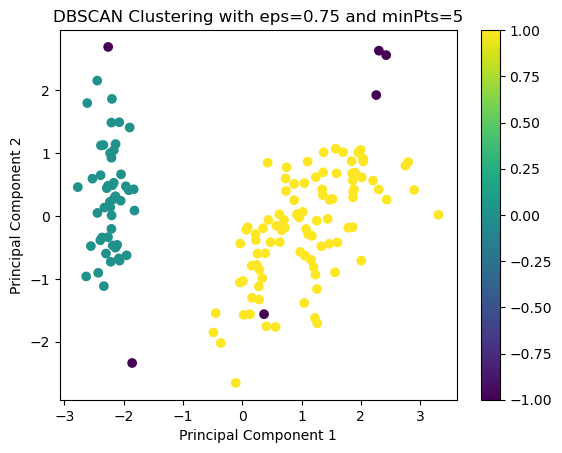

In [65]:
# 根据k-距离图选择的eps和minPts
eps = 0.75  # 这个值应基于k-距离图的观察进行调整
minPts = 5  # 假设基于领域的需求和先前的测试

labels = dbscan(X_scaled, eps, minPts)

# 使用PCA进行降维以便可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering with eps={} and minPts={}'.format(eps, minPts))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

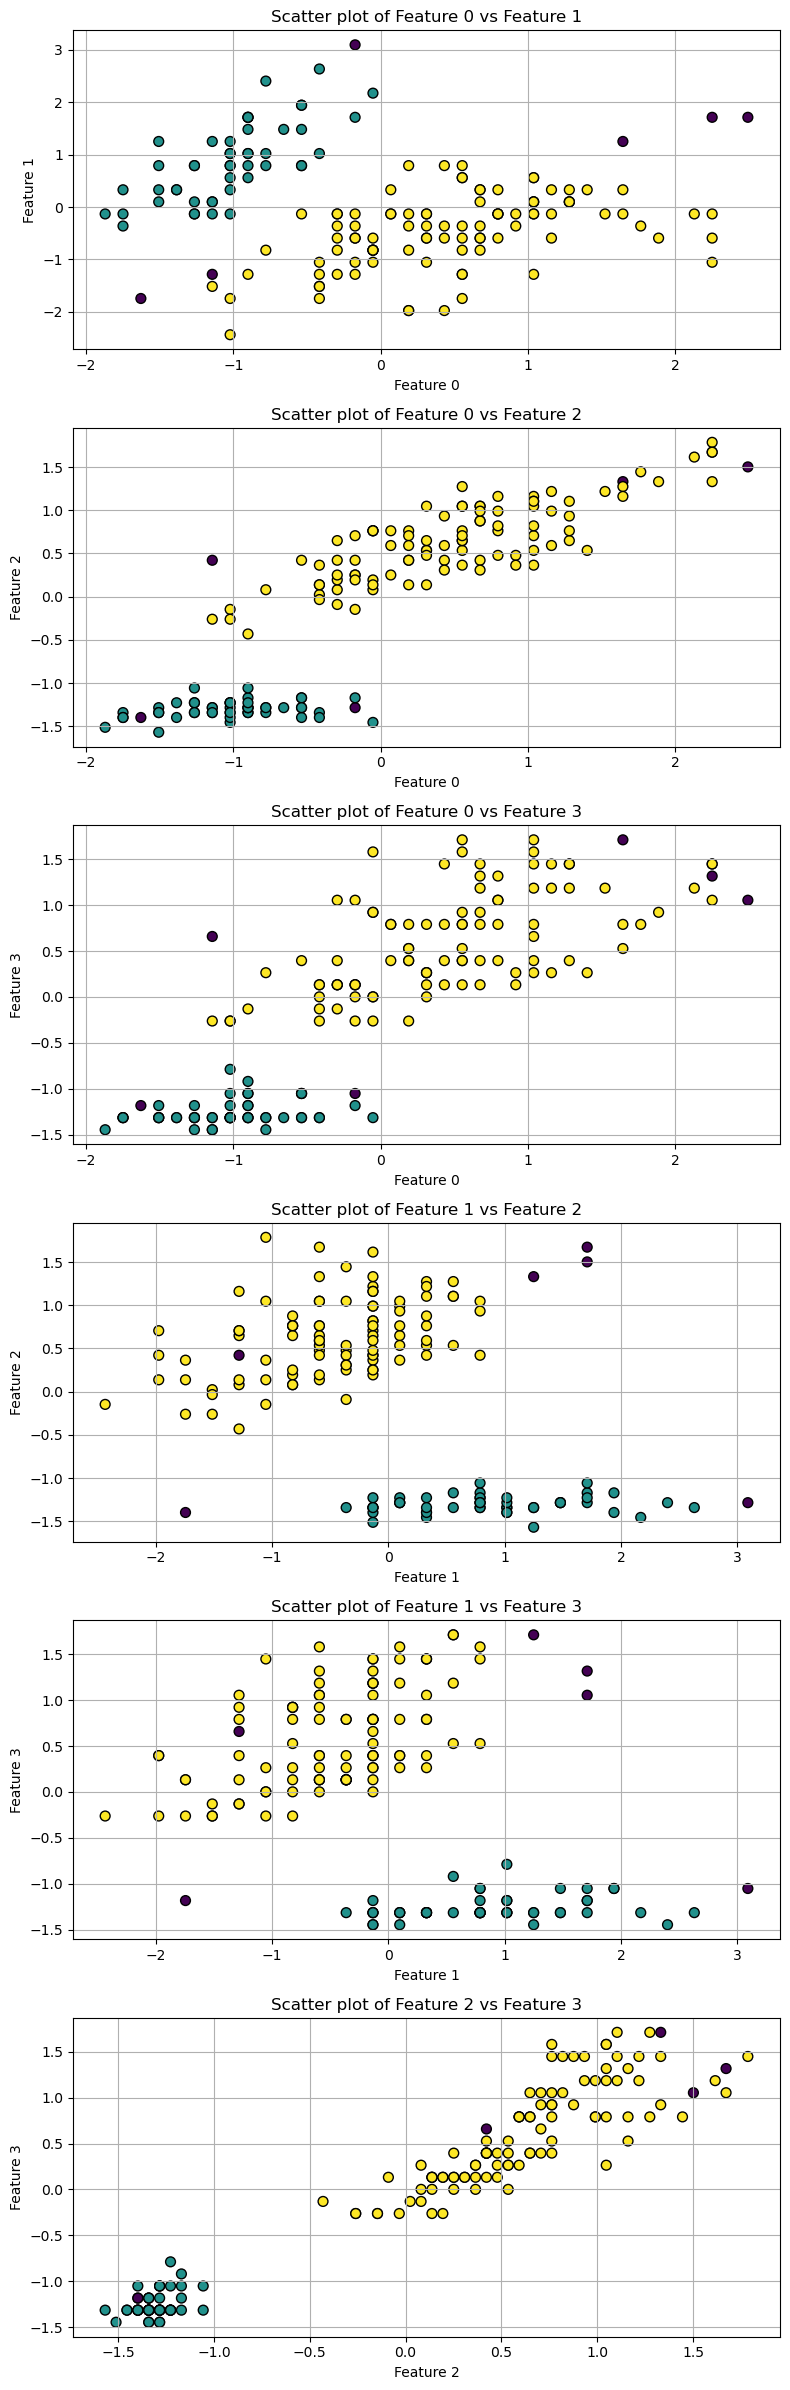

In [66]:
from itertools import combinations
eps = 0.75  # 这个值应基于k-距离图的观察进行调整
minPts = 5  # 假设基于领域的需求和先前的测试

# 应用自定义DBSCAN函数进行聚类
labels = dbscan(X_scaled, eps, minPts)

# 特征对组合
feature_combinations = list(combinations(range(X_scaled.shape[1]), 2))

# 创建散点图矩阵
fig, axes = plt.subplots(len(feature_combinations), 1, figsize=(8, len(feature_combinations) * 4))
if len(feature_combinations) == 1:  # 如果只有一个组合，将axes转为列表
    axes = [axes]

for ax, (i, j) in zip(axes, feature_combinations):
    ax.scatter(X_scaled[:, i], X_scaled[:, j], c=labels, cmap='viridis', edgecolor='k', s=50)
    ax.set_xlabel(f'Feature {i}')
    ax.set_ylabel(f'Feature {j}')
    ax.set_title(f'Scatter plot of Feature {i} vs Feature {j}')
    ax.grid(True)

plt.tight_layout()
plt.show()